In [151]:
CIFAR_DIR='cifar-10-batches-py/'

In [152]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [153]:
dirs=['batches.meta','data_batch_1','data_batch_2','data_batch_3',
      'data_batch_4','data_batch_5','test_batch']

In [154]:
all_data=[0,1,2,3,4,5,6]

In [155]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [156]:
batch_meta=all_data[0]
data_batch1=all_data[1]
data_batch2=all_data[2]
data_batch3=all_data[3]
data_batch4=all_data[4]
data_batch5=all_data[5]
test_batch=all_data[6]

In [157]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [158]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [160]:
x=data_batch1[b'data']

In [161]:
x=x.reshape(10000, 3,32,32).transpose(0,2,3,1).astype('uint8')

In [162]:
x[0].shape

(32, 32, 3)

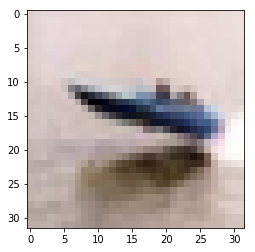

In [163]:
plt.imshow(x[441])

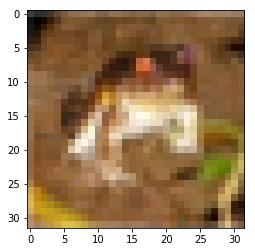

In [164]:
x=data_batch1[b'data']
all_images=x.reshape(10000, 3, 32,32)
sample=all_images[0]
sample.shape
plt.imshow(sample.transpose(1,2,0))

In [165]:
def one_hot_encode(vec, vals=10):
    n=len(vec)
    out=np.zeros((n,vals))
    out[range(n), vec]=1
    return out

In [166]:
class cifarHelfer():
    
    def __init__(self):
        self.i=0
        self.all_train_batches=[data_batch1,data_batch2,data_batch3,
                               data_batch4,data_batch5]
        self.test_batch=[test_batch]
        self.test_images=None
        self.test_labels=None
    
    def set_up_images(self):
        self.training_images=np.vstack([d[b'data'] for d in self.all_train_batches])
        train_len=len(self.training_images)
        self.training_images=self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels=one_hot_encode(np.hstack([d[b'data'] for d in self.all_train_batches]))
        print('Setting up test Image and Labels')
        
        self.test_images=np.vstack([d[b'data'] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images =self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels=one_hot_encode(np.hstack([d[b'labels'] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        x=self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y=self.training_labels[self.i:self.i+batch_size]
        self.i=(self.i + batch_size) % len(self.training_images)
        return x,y

In [167]:
ch=cifarHelfer()
ch.set_up_images()

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (10000,) (10000,15360) 

In [ ]:
import tensorflow as tf

In [ ]:
x=tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true=tf.placeholder(tf.float32,shape=[None,10])

In [ ]:
hold_prob=tf.placeholder(tf.float32)

In [ ]:
def init_weight(shape):
    init_random_dist=tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)
def init_bias(shape):
    init_bias_vals=tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)
def conv2d(x,w):
    return tf.nn.conv2d(x, w,strides=[1,1,1,1], padding='SAME')
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
def convolutional_layer(input_x,shape):
    w=init_weight(shape)
    b=init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, w) + b)

def normal_full_layer(input_layer, size):
    input_size=int(input_layer.get_shape()[1])
    w=init_weight([input_size,size])
    b=init_bias([size])
    return tf.matmul(input_layer, w) + b
    

In [ ]:
#layers
convo_1=convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling=max_pool_2by2(convo_1)

In [ ]:
convo_2=convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling=max_pool_2by2(convo_2)

In [ ]:
#flatten
convo_2_flat=tf.reshape(convo_2_pooling,[-1,8*8*64])

In [ ]:
full_layer_one=tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [ ]:
full_one_dropout=tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [ ]:
y_pred=normal_full_layer(full_one_dropout,10)

In [ ]:
#loss fn
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [ ]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.001)
train=optimizer.minimize(cross_entropy)

In [ ]:
init=tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(5000):
        batch=ch.next_batch(100)
        sess.run(train,feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.5})
        if i%100 ==0:
            print('STEP: {}'.format(i))
            matches=tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc=tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')